Relevant papers and tutorials

https://arxiv.org/pdf/1706.03762.pdf

https://www.youtube.com/watch?v=U0s0f995w14

http://peterbloem.nl/blog/transformers

Import modules

In [ ]:
import torch
import torch.nn as nn
import math

Multi-head attention

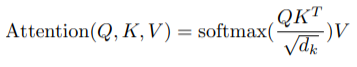

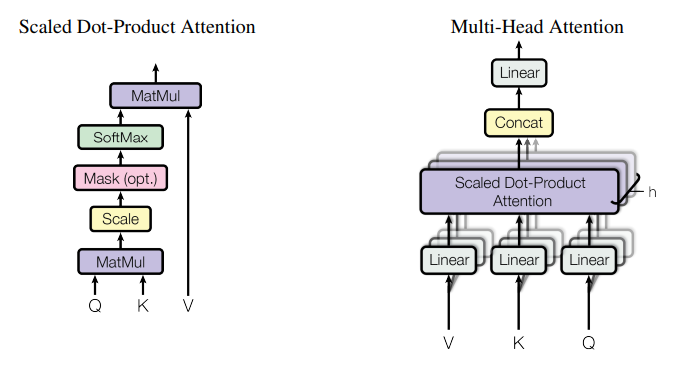

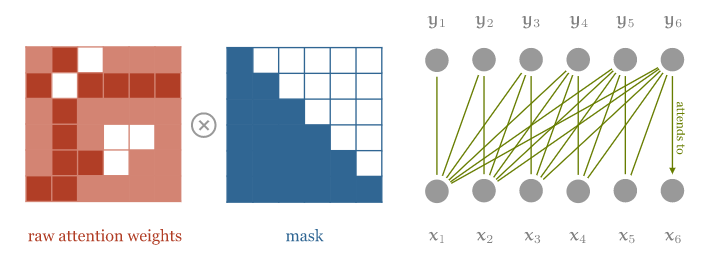

In [ ]:
class multihead_attention(nn.Module):
  def __init__(self, dmodel, h):
    super(multihead_attention, self).__init__()
    self.dmodel = dmodel
    self.h = h #h stands for number of heads
    self.dk = self.dmodel//self.h #dk = dv = dmodel/h = 64, dk stands for dimension of keys
    self.softmax = nn.Softmax(dim=2) #https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html dim=2 as all dk values should become weights
    
    assert(self.dk*self.h == self.dmodel, "Error: Dividing dmodel by h leaves a non-zero remainder")

    #more efficient to combine matrices across different attention heads
    self.W_queries = nn.Linear(self.dk, self.dmodel, bias=False)
    self.W_keys = nn.Linear(self.dk, self.dmodel, bias=False)
    self.W_values = nn.Linear(self.dk, self.dmodel, bias=False)
    self.concatheads = nn.Linear(self.dmodel, self.dk, bias=False)
    
  def forward(self, q, k, v, mask):
    #NOTE: MULTI-HEAD ATTENTION SOMETIMES REQUIRES DIFFERENT INPUTS SO YOU CAN't JUST INPUT ONE "X"
    #input dimensions: (batch_size, query/key/value dimension, dk)
    #batch dimension = number of attention layers???
    batch_size, key_length = k.shape[0], k.shape[1]
    value_length, query_length = v.shape[1], q.shape[1]

    #creates 3 separate queries, keys and values
    #print("key_length, value_length, query_length:", key_length, value_length, query_length)
    queries = self.W_queries(q).view(batch_size, query_length, self.h, self.dk) #expands inputs with dk size to h*dk size, splits into different heads
    keys = self.W_keys(k).view(batch_size, key_length, self.h, self.dk)
    values = self.W_values(v).view(batch_size, value_length, self.h, self.dk)

    queries = torch.transpose(queries, 1, 2).contiguous().view(batch_size*self.h, query_length, self.dk) #transposes dimensions words and h, then "folds" h to batch_size
    keys = torch.transpose(keys, 1, 2).contiguous().view(batch_size*self.h, key_length, self.dk)
    values = torch.transpose(values, 1, 2).contiguous().view(batch_size*self.h, value_length, self.dk)

    #applies attention and linear layer
    out = torch.bmm(queries, torch.transpose(keys,1,2)) #each resulting entry is a dot product of the two embedding vectors of two words
    ###if mask is not None:
    ###  out = out.masked_fill(mask == 0, value = 1e-30) #prevents looking at later words
    out = self.softmax(out*( 1/self.dk**(1/2) )) #scaling/normalizing by length of vector with 1 in each of dk directions to prevent dot products from becoming too large, softmax
    #out = out.view()
    out = torch.bmm(out, values).view(batch_size, self.h, query_length, self.dk)
    out = torch.transpose(out, 1, 2).contiguous().view(batch_size, query_length, self.h*self.dk)
    out = self.concatheads(out) #resulting dimensions (batch_size, query_length, self.dk), same as input dimensions

    return out

<ipython-input-31-1e2ef11c8400>:9: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.dk*self.h == self.dmodel, "Error: Dividing dmodel by h leaves a non-zero remainder")


Transformer Block

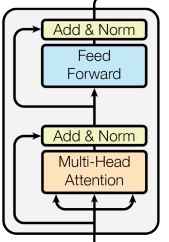

In [ ]:
class Transformer_Block(nn.Module):
  def __init__(self, dmodel, h, ff_expansion, dropout):
    super(Transformer_Block, self).__init__()
    self.multihead_attention = multihead_attention(dmodel, h)
    self.dk = dmodel // h
    assert(self.dk*h == dmodel, "Error: Dividing dmodel by h leaves a non-zero remainder")
    self.layernorm1 = nn.LayerNorm(normalized_shape=self.dk) #check if normalized_shape makes sense, check whether other params require inputs
    self.feedforward = nn.Sequential(nn.Linear(self.dk, self.dk*ff_expansion),
                                     nn.ReLU(),
                                     nn.Linear(self.dk*ff_expansion, self.dk))
    self.layernorm2 = nn.LayerNorm(normalized_shape=self.dk) #check if normalized_shape makes sense, check whether other params require inputs
    self.dropout = nn.Dropout(dropout)

  def forward(self, q, k, v, mask):
    identity1 = q.clone()
    attention = self.multihead_attention(q, k, v, mask)
    x = self.layernorm1(attention + identity1)
    identity2 = x.clone()
    ff = self.feedforward(x)
    out = self.dropout(self.layernorm2(ff + identity2))
    return out

<ipython-input-3-64e28b988f62>:6: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.dk*h == dmodel, "Error: Dividing dmodel by h leaves a non-zero remainder")


Encoder

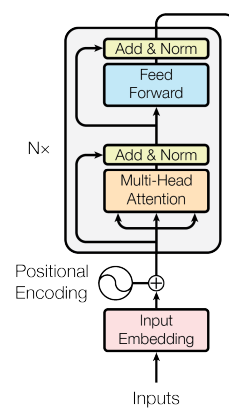

In [ ]:
class Encoder(nn.Module):
  def __init__(self, source_vocab_size, num_layers, device, dmodel, h, ff_expansion, dropout, max_length):
    super(Encoder, self).__init__()
    self.dk = dmodel // h
    assert(self.dk*h == dmodel, "Error: Dividing dmodel by h leaves a non-zero remainder")
    self.device = device
    self.word_embedding = nn.Embedding(source_vocab_size, self.dk)
    self.position_embedding = nn.Embedding(max_length, self.dk)

    self.layers = nn.ModuleList(
        [
         Transformer_Block(dmodel, h, ff_expansion, dropout) for i in range(num_layers)
        ]
    )
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x, mask):
    batch_size, num_words = x.shape
    positions = torch.arange(0, num_words).expand(batch_size, num_words).to(self.device)

    out = self.dropout(self.word_embedding(x) + self.position_embedding(positions)) #dimensions: batch_size, num_words, self.dk
    for layer in self.layers:
      out = layer(out, out, out, mask)
    
    return out

<ipython-input-4-685b42c8582e>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.dk*h == dmodel, "Error: Dividing dmodel by h leaves a non-zero remainder")


Decoder block

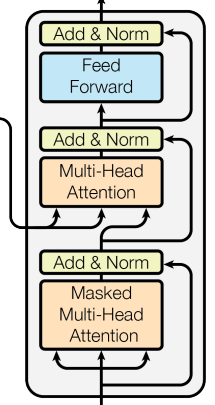

In [ ]:
class Decoder_Block(nn.Module):
  def __init__(self, dmodel, h, ff_expansion, dropout, device):
    super(Decoder_Block, self).__init__()
    self.multihead_attention = multihead_attention(dmodel, h)
    self.dk = dmodel // h
    assert(self.dk*h == dmodel, "Error: Dividing dmodel by h leaves a non-zero remainder")
    self.layernorm = nn.LayerNorm(normalized_shape = self.dk)
    self.dropout = nn.Dropout(dropout)
    self.transformer_block = Transformer_Block(dmodel, h, ff_expansion, dropout)
  
  #"the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack"
  def forward(self, x, encoder_output, source_mask, target_mask):
    identity = x.clone()
    attention = self.multihead_attention(x, x, x, target_mask)
    query = self.dropout(self.layernorm(attention + identity))
    out = self.transformer_block(query, encoder_output, encoder_output, source_mask)
    return out

<ipython-input-5-1286cf4b525e>:6: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.dk*h == dmodel, "Error: Dividing dmodel by h leaves a non-zero remainder")


Decoder

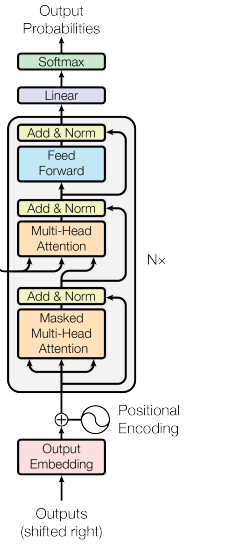

In [ ]:
class Decoder(nn.Module):
  def __init__(self, target_vocab_size, num_layers, device, dmodel, h, ff_expansion, dropout, max_length):
    super(Decoder, self).__init__()
    self.dk = dmodel // h
    assert(self.dk*h == dmodel, "Error: Dividing dmodel by h leaves a non-zero remainder")
    self.device = device
    self.word_embedding = nn.Embedding(target_vocab_size, self.dk)
    self.position_embedding = nn.Embedding(max_length, self.dk)

    self.dropout = nn.Dropout(dropout)
    self.layers = nn.ModuleList(
        [
         Decoder_Block(dmodel, h, ff_expansion, dropout, device) for i in range(num_layers)
        ]
    )
    self.fc = nn.Linear(self.dk, target_vocab_size)
    
    #self.softmax = nn.Softmax(dim=2) #no softmax
  
  def forward(self, x, encoder_output, source_mask, target_mask):
    batch_size, num_words = x.shape
    positions = torch.arange(0, num_words).expand(batch_size, num_words).to(self.device)
    x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

    for layer in self.layers:
      x = layer(x, encoder_output, source_mask, target_mask)
    
    out = self.fc(x)

    return out

<ipython-input-6-8bc11b885e50>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.dk*h == dmodel, "Error: Dividing dmodel by h leaves a non-zero remainder")


Transformer

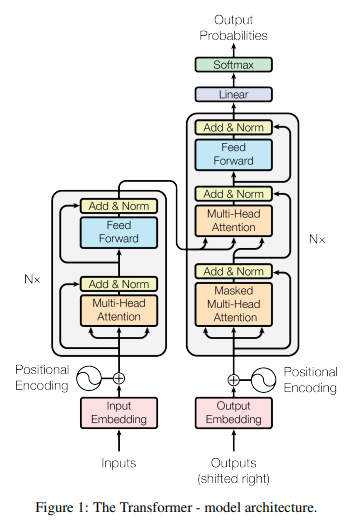

In [ ]:
class The_Transformer(nn.Module):
  def __init__(self, source_vocab_size, target_vocab_size, source_pad_index, target_pad_index, 
               dmodel=512, h=8, num_layers=6, ff_expansion=4, dropout=0.1, device='cuda', max_length=100):
    super(The_Transformer, self).__init__()

    self.encoder = Encoder(source_vocab_size, num_layers, device, dmodel, h, ff_expansion, dropout, max_length)
    self.decoder = Decoder(target_vocab_size, num_layers, device, dmodel, h, ff_expansion, dropout, max_length)

    self.source_vocab_size = source_vocab_size
    self.target_vocab_size = target_vocab_size
    self.source_pad_index = source_pad_index
    self.target_pad_index = target_pad_index
    self.device = device

  #don't understand the mask code 
  #make source mask function
  def make_source_mask(self, source):
    source_mask = (source != self.source_pad_index).unsqueeze(1).unsqueeze(2)
    #dimensions: (batch_size, 1, 1, source_length)
    return source_mask.to(self.device)
  #make target mask function

  def make_target_mask(self, target):
    N, target_length = target.shape
    target_mask = torch.tril(torch.ones((target_length, target_length))).expand(N, 1, target_length, target_length)
    return target_mask.to(self.device)
  
  def forward(self, source, target):
    source_mask = self.make_source_mask(source)
    target_mask = self.make_target_mask(target)
    encoder_source = self.encoder(source, source_mask)
    out = self.decoder(target, encoder_source, source_mask, target_mask)
    return out

Checking if it runs

In [ ]:
if __name__ == "__main__":
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  x = torch.tensor([[1,5,6,4,3,9,5,2,8], [1,8,7,3,4,5,6,7,2]]).to(device)
  trg = torch.tensor([[1,7,4,3,5,9,2,8], [1,5,6,2,4,7,6,2]]).to(device)

  src_pad_idx = 0
  trg_pad_idx = 0
  src_vocab_size = 10
  trg_vocab_size = 10
  model = The_Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx).to(device)
  out = model(x, trg[:, :-1])
  print(out.shape)

key_length, value_length, query_length: 9 9 9
key_length, value_length, query_length: 9 9 9
key_length, value_length, query_length: 9 9 9
key_length, value_length, query_length: 9 9 9
key_length, value_length, query_length: 9 9 9
key_length, value_length, query_length: 9 9 9
key_length, value_length, query_length: 7 7 7
key_length, value_length, query_length: 9 9 7
key_length, value_length, query_length: 7 7 7
key_length, value_length, query_length: 9 9 7
key_length, value_length, query_length: 7 7 7
key_length, value_length, query_length: 9 9 7
key_length, value_length, query_length: 7 7 7
key_length, value_length, query_length: 9 9 7
key_length, value_length, query_length: 7 7 7
key_length, value_length, query_length: 9 9 7
key_length, value_length, query_length: 7 7 7
key_length, value_length, query_length: 9 9 7
torch.Size([2, 7, 10])
